In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
# os._exit(00)
os.chdir('drive/MyDrive/charts/charts')


In [ ]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler


import torch
from torchvision import datasets, transforms

image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5]),
        transforms.Grayscale(1)
    ]),
    "test": transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Grayscale(1),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ])
}

dataset = datasets.ImageFolder('train_val', transform = image_transforms["train"])


dataset_size = len(dataset)
dataset_indices = list(range(dataset_size))
np.random.shuffle(dataset_indices)
val_split_index = int(np.floor(0.2 * dataset_size))
train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

import glob 
from PIL import Image
class TestDataset(Dataset):
    def __init__(self, path, transform=None):
        self.image_paths = glob.glob(path + '*.png')
        self.transform = transform

    def __getitem__(self, index):
        x = Image.open(self.image_paths[index]).convert('RGB')
        if self.transform is not None:
            x = self.transform(x)

        return x

    def __len__(self):
        return len(self.image_paths)
dataset_test = TestDataset("test/", transform= image_transforms["test"])
dataset_test
train_loader = DataLoader(dataset=dataset, shuffle=False, batch_size=16, sampler=train_sampler)
val_loader = DataLoader(dataset=dataset, shuffle=False, batch_size=16, sampler=val_sampler)
test_loader = DataLoader(dataset=dataset_test, shuffle=False, batch_size=16)


## Vision Transformer

In [ ]:
def patchify(images, n_patches):
    n, c, h, w = images.shape

    patches = torch.zeros(n, n_patches ** 2, h * w // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches



class Transformer(nn.Module):
    def __init__(self, input_shape, n_patches=7, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(Transformer, self).__init__()
        self.device = device

        # Input and patches sizes
        self.input_shape = input_shape
        self.n_patches = n_patches
        self.n_heads = n_heads
        assert input_shape[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert input_shape[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (input_shape[1] / n_patches, input_shape[2] / n_patches)
        self.hidden_d = hidden_d

        # 1) Linear mapper
        self.input_d = int(input_shape[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        # (In forward method)

        # 4a) Layer normalization 1
        self.ln1 = nn.LayerNorm((self.n_patches ** 2 + 1, self.hidden_d))

        # 4b) Multi-head Self Attention (MSA) and classification token
        self.msa = self_attention(self.hidden_d, n_heads)

        # 5a) Layer normalization 2
        self.ln2 = nn.LayerNorm((self.n_patches ** 2 + 1, self.hidden_d))

        # 5b) Encoder MLP
        self.enc_mlp = nn.Sequential(
            nn.Linear(self.hidden_d, self.hidden_d),
            nn.ReLU()
        )

        # 6) Classification MLP
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, w, h = images.shape
        patches = patchify(images, self.n_patches)

        # Running linear layer for tokenization
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])

        # Adding positional embedding
        tokens += get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d).repeat(n, 1, 1)

        # TRANSFORMER ENCODER BEGINS ###################################
        # NOTICE: MULTIPLE ENCODER BLOCKS CAN BE STACKED TOGETHER ######
        # Running Layer Normalization, MSA and residual connection
        out = tokens + self.msa(self.ln1(tokens))

        # Running Layer Normalization, MLP and residual connection
        out = out + self.enc_mlp(self.ln2(out))
        # TRANSFORMER ENCODER ENDS   ###################################

        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out)



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

np.random.seed(0)
torch.manual_seed(0)


## Multi Head Self Attention Module

In [ ]:
class self_attention(nn.Module):
    def __init__(self, d, n_heads=2):
        super(self_attention, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])


def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [ ]:
next(iter(train_loader))[0].shape

torch.Size([16, 1, 28, 28])

In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Transformer((1, 28, 28), n_patches=7, hidden_d=20, n_heads=2, out_d=10)

N_EPOCHS = 5
LR = 0.01

# Training loop
optimizer = Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss()

for epoch in tqdm(range(N_EPOCHS), desc="Training"):
    train_epoch_loss = 0
    train_epoch_acc = 0
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}", leave=False):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y) / len(x)

        train_loss += loss.detach().cpu().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

# Test loop


Training:  20%|██        | 1/5 [02:52<11:29, 172.26s/it]

Epoch 1/5 loss: 6.92



Training:  40%|████      | 2/5 [02:56<03:40, 73.55s/it] 

Epoch 2/5 loss: 6.14



Training:  60%|██████    | 3/5 [03:01<01:23, 41.95s/it]

Epoch 3/5 loss: 5.73



Training:  80%|████████  | 4/5 [03:05<00:27, 27.08s/it]

Epoch 4/5 loss: 5.55



Training: 100%|██████████| 5/5 [03:10<00:00, 38.02s/it]


Epoch 5/5 loss: 5.50


Testing:   0%|          | 0/4 [00:00<?, ?it/s]


RuntimeError: ignored

In [ ]:

for batch in tqdm(val_loader, desc="Testing"):
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_hat = model(x)
    loss = criterion(y_hat, y) / len(x)
    test_loss += loss.detach().cpu().item()
    val_epoch_loss += train_loss.item()

    correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
    total += len(x)
print(f"Test loss: {test_loss:.2f}")
print(f"Test accuracy: {correct / total * 100:.2f}%")



Testing: 100%|██████████| 13/13 [00:45<00:00,  3.52s/it]

Test loss: 1.54
Test accuracy: 76.00%


## GAN

In [6]:
import torch
from torchvision import datasets, transforms
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler



In [8]:
import os
import numpy as np
import math
import sys
from time import time
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
 
os.makedirs("images", exist_ok=True)
 
class Opt(object):
    dim = 10
    n_epochs = 200
    batch_size = dim*dim
    lr = 0.0002
    b1 = 0.5
    b2 = 0.999
    n_cpu = 1
    latent_dim = 100
    img_size = 28
    channels = 1
    sample_interval = 400
opt = Opt()  
 
img_shape = (opt.channels, opt.img_size, opt.img_size)
 
cuda = True if torch.cuda.is_available() else False
 
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img
 
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity
 
bce_loss = torch.nn.BCELoss()
generator = Generator()
discriminator = Discriminator()
 
if cuda:
    generator.cuda()
    discriminator.cuda()
    bce_loss.cuda()


transform_1 = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((28,28)),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5]),
        transforms.Grayscale(1)                           
    ])

dataset = datasets.ImageFolder('train_val', transform = transform_1)
train_loader = DataLoader(dataset, batch_size= Opt.batch_size, shuffle=True)

# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
 
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
 

In [9]:
saved_imgs = []
for epoch in range(opt.n_epochs):
    print('Epoch ' + str(epoch) + ' training...' , end=' ')
    start = time()
    for i, (imgs, _) in enumerate(train_loader):
        real = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)
        real_imgs = Variable(imgs.type(Tensor))
        #  train Generator
        generator_optimizer.zero_grad()
        # sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))
        # generate a batch of images
        gen_imgs = generator(z)
        # loss measures generator's ability to fool the discriminator:
        # for the generated images, the generator wants the discriminator to think they're real (1)
        # so if the discriminator(gen_imgs) == real == 1, then the generator is doing a good job, there is no loss
        generator_loss = bce_loss(discriminator(gen_imgs), real)
        generator_loss.backward()
        generator_optimizer.step()
        # train Discriminator
        discriminator_optimizer.zero_grad()
        # loss measure discriminator's ability to classify real from generated samples:
        real_loss = bce_loss(discriminator(real_imgs), real)
        fake_loss = bce_loss(discriminator(gen_imgs.detach()), fake)
        discriminator_loss = (real_loss + fake_loss) / 2
        discriminator_loss.backward()
        discriminator_optimizer.step()
        batches_done = epoch * len(train_loader) + i
    end = time()
    elapsed = end - start
    print('done, took %.1f seconds.' % elapsed)
    grid = torchvision.utils.make_grid(gen_imgs.data.cpu(), nrow=opt.dim)
    img = (np.transpose(grid.detach().numpy(), (1, 2 ,0)) * 255).astype(np.uint8)
    saved_imgs.append(img)

Epoch 0 training... done, took 169.7 seconds.
Epoch 1 training... done, took 2.9 seconds.
Epoch 2 training... done, took 2.9 seconds.
Epoch 3 training... done, took 2.9 seconds.
Epoch 4 training... done, took 2.9 seconds.
Epoch 5 training... done, took 2.9 seconds.
Epoch 6 training... done, took 2.9 seconds.
Epoch 7 training... done, took 2.9 seconds.
Epoch 8 training... done, took 2.9 seconds.
Epoch 9 training... done, took 2.9 seconds.
Epoch 10 training... done, took 2.9 seconds.
Epoch 11 training... done, took 2.9 seconds.
Epoch 12 training... done, took 2.9 seconds.
Epoch 13 training... done, took 2.9 seconds.
Epoch 14 training... done, took 2.8 seconds.
Epoch 15 training... done, took 2.9 seconds.
Epoch 16 training... done, took 2.8 seconds.
Epoch 17 training... done, took 2.9 seconds.
Epoch 18 training... done, took 2.9 seconds.
Epoch 19 training... done, took 2.9 seconds.
Epoch 20 training... done, took 2.9 seconds.
Epoch 21 training... done, took 2.9 seconds.
Epoch 22 training.

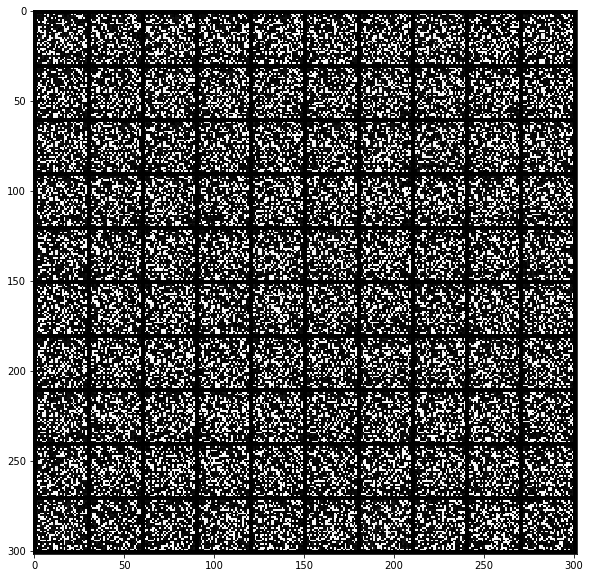

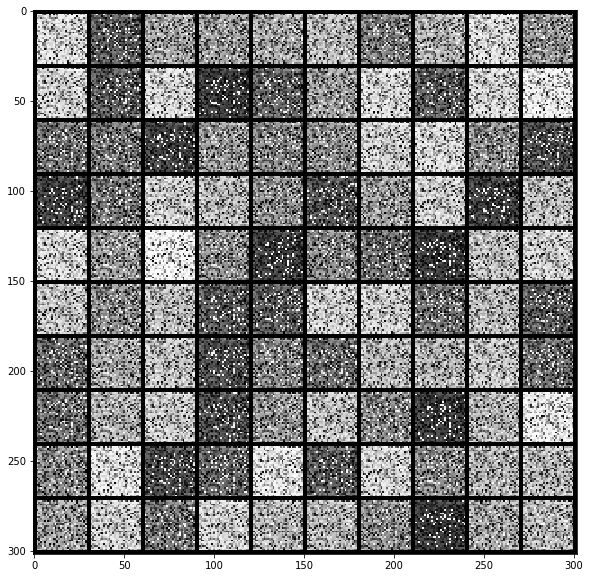

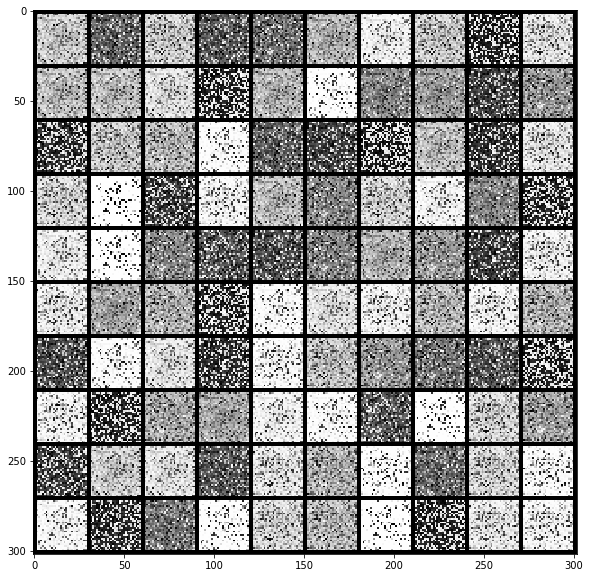

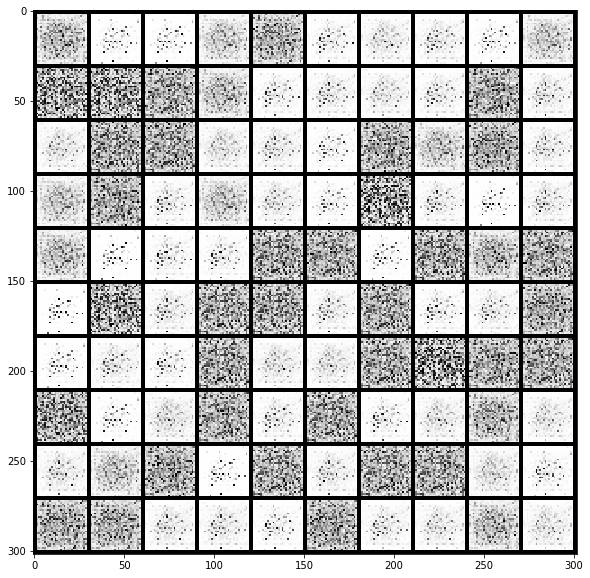

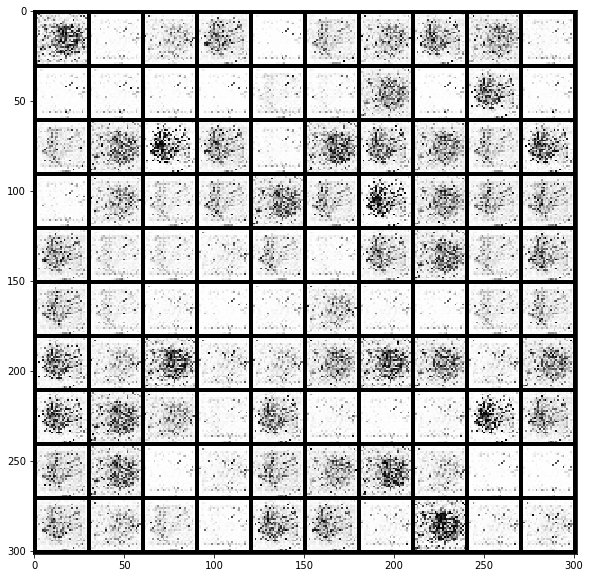

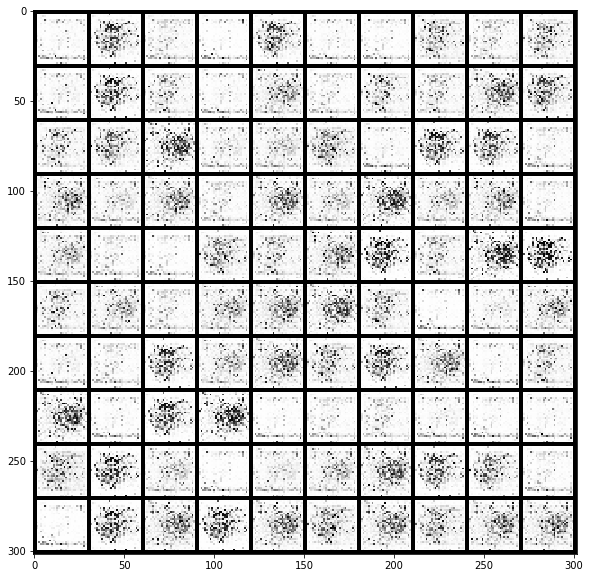

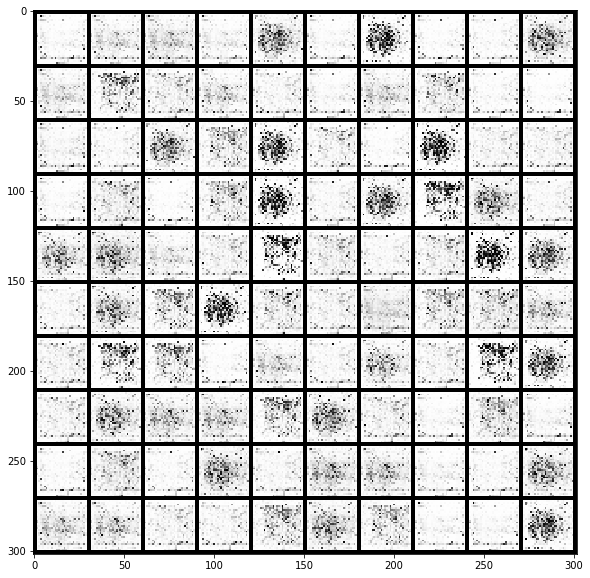

In [10]:
img_indexes = [0, 4, 9, 49, 99, 149, 199]
for i in img_indexes:
    plt.figure(figsize = (opt.dim, opt.dim))
    plt.imshow(saved_imgs[i], interpolation='nearest')